# Explore here

In [8]:
# Your code here
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
import joblib

# Load dataset
url = "https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv"
sales = pd.read_csv(url, parse_dates=['date'], index_col='date')
sales = sales.asfreq('MS')  # Set frequency to Month Start

print("Dataset head:")
print(sales.head())

# Check data length and fix if needed
print(f"\nOriginal data length: {len(sales)}")

# If data is too short for decomposition, use a shorter period
period = 6 if len(sales) < 24 else 12

Dataset head:
                                 sales
date                                  
2022-10-01 17:10:08.079328  127.475050
2022-11-01 17:10:08.079328  202.473420
2022-12-01 17:10:08.079328  284.807191
2023-01-01 17:10:08.079328  363.458044
2023-02-01 17:10:08.079328  448.153727

Original data length: 12


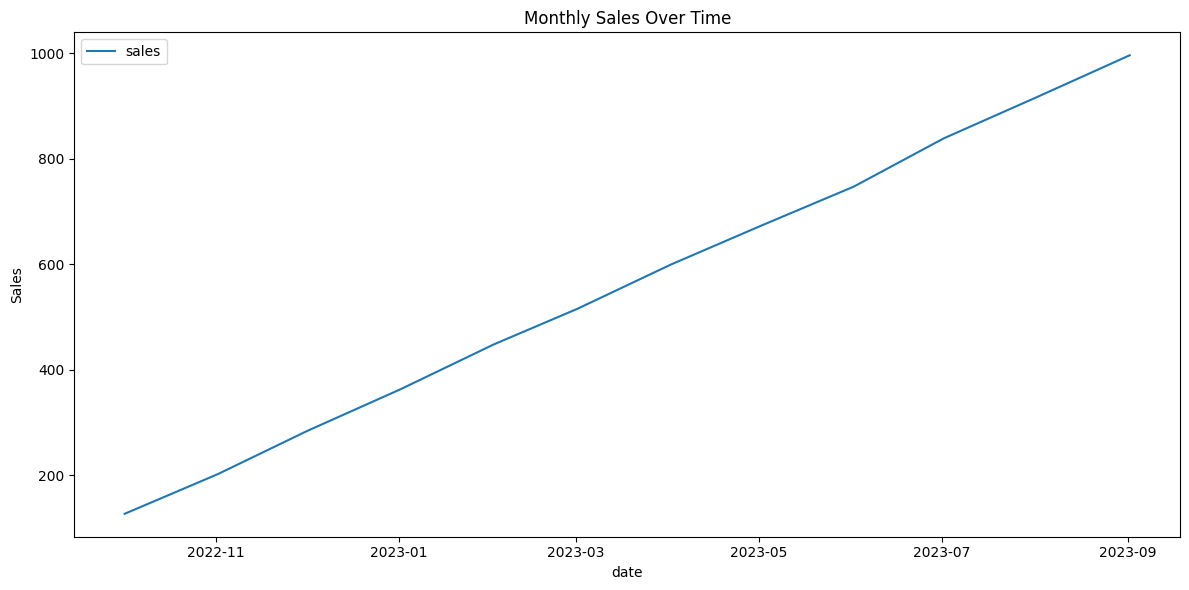


Time Series Analysis:
Tensor (frequency): MS
Date Range: 2022-10-01 17:10:08.079328 to 2023-09-01 17:10:08.079328
Missing Values: 0


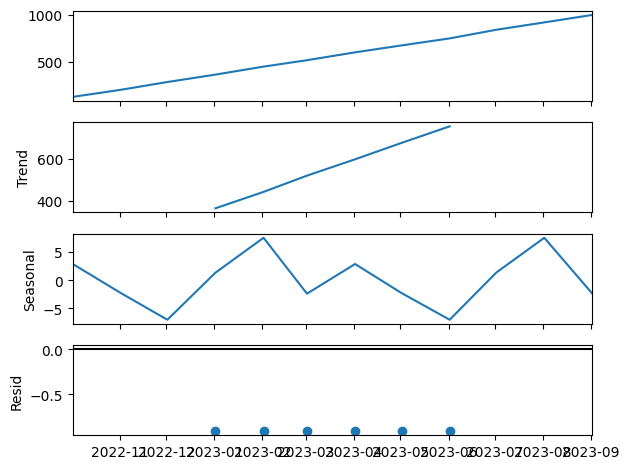


Stationarity Check:
ADF Statistic: 0.5315
p-value: 0.9858
Critical Values:
	1%: -4.4731
	5%: -3.2899
	10%: -2.7724
Series is non-stationary


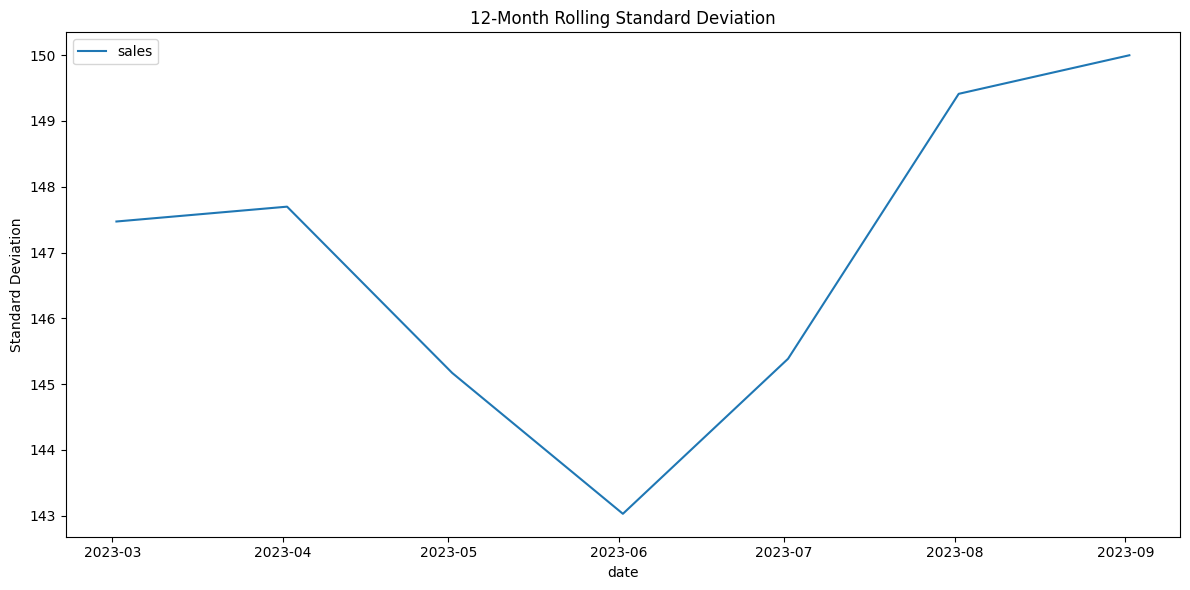

In [9]:
# Plot the time series
plt.figure(figsize=(12, 6))
sns.lineplot(data=sales)
plt.title('Monthly Sales Over Time')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# Time series analysis
print("\n" + "="*50)
print("Time Series Analysis:")
print(f"Tensor (frequency): {sales.index.freqstr}")
print(f"Date Range: {sales.index.min()} to {sales.index.max()}")
print(f"Missing Values: {sales.isnull().sum().values[0]}")

# Decompose the series
try:
    # Use dynamic period we calculated earlier
    decomposition = seasonal_decompose(sales, period=period)
    decomposition.plot()
    plt.tight_layout()
    plt.show()
except ValueError as e:
    print(f"Skipping decomposition: {str(e)}")
    print("Using simpler analysis methods due to short dataset")

# Stationarity test
def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")
    return result[1] > 0.05

print("\nStationarity Check:")
is_non_stationary = test_stationarity(sales['sales'])
print(f"Series is {'non-stationary' if is_non_stationary else 'stationary'}")

# Variability analysis
rolling_window = min(6, len(sales) // 2)
rolling_std = sales.rolling(window=rolling_window).std()
plt.figure(figsize=(12, 6))
sns.lineplot(data=rolling_std)
plt.title('12-Month Rolling Standard Deviation')
plt.ylabel('Standard Deviation')
plt.tight_layout()
plt.show()

In [10]:
# Dynamic train-test split
test_size = min(3, len(sales) // 3)  
train = sales.iloc[:-test_size]
test = sales.iloc[-test_size:]
use_seasonal = len(train) > 24  

print(f"\nTrain size: {len(train)}, Test size: {len(test)}")
print(f"Seasonality enabled: {use_seasonal}")

# Find best ARIMA parameters
model = auto_arima(
    train,
    seasonal=use_seasonal,
    m=period if use_seasonal else 0,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(model.summary())
# Check if model was properly fitted
if len(train) < 5:  # Reduced minimum requirement
    print("Warning: Insufficient data for reliable ARIMA modeling")
    print("Proceeding with predictions but results may be unstable")


Train size: 9, Test size: 3
Seasonality enabled: False
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=138.814, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=111.690, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=82.123, Time=0.09 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=84.196, Time=0.12 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=89.111, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=89.179, Time=0.16 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=96.004, Time=0.18 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 1.115 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -37.062
Date:                Mon, 14 Jul 2025   AIC                             82.123
Time:                        21:03:39   BIC                             82.912
Sample:                    10-01-2022   HQIC                            80.421
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9975      0.004    482.992      0.000       1.989   

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


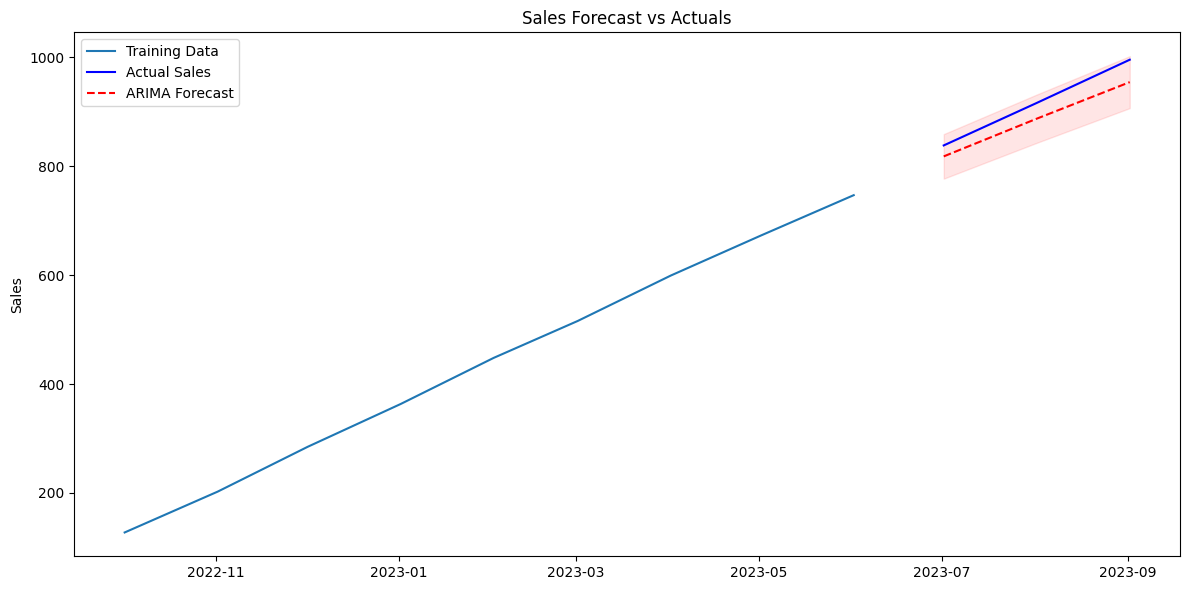

Mean Absolute Error: 30.08
Error Percentage: 3.28%


In [11]:
# Generate predictions
forecast = model.predict(n_periods=len(test))
forecast = pd.Series(forecast, index=test.index)

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Sales', color='blue')
plt.plot(forecast.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.fill_between(forecast.index, 
                 forecast * 0.95, 
                 forecast * 1.05, 
                 color='red', alpha=0.1)
plt.title('Sales Forecast vs Actuals')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate metrics
mae = mean_absolute_error(test, forecast)
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Error Percentage: {mae/test.mean().values[0]*100:.2f}%")

In [12]:
joblib.dump(model, 'arima_sales_forecast_model.pkl')
print("Model saved successfully!")

Model saved successfully!
